# Welcome to Ochem Bro v1!
This is the first iteration of Ochem Bro. The main objectives are to import the datasets needed and train a LCS model to create rules that can correctly identy chemical compounds according to IUPAC convention.
This project will (hopefully) expand beyond just the simple nomenclature objective to perhaps predict intrinsic chemical properties to a higher degree of accuracy, or even completing synthesis reactions.
This model is planned to be integrated into a full web-app for real-time utilization on a drawing tool.

## Part 1: Prerequisites
This is just all the set up

In [349]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable


In [199]:
!pip install rdkit

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for rdkit from https://files.pythonhosted.org/packages/72/64/f96f4a72052be7580ab825279cc71653a476c023c53828765be520db47e6/rdkit-2024.9.6-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 87.8 MB/s eta 0:00:00:00:0100:01


In [231]:
#Whole lotta imports
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import os
import json
import re
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import datasets, layers, models
from keras.utils import Sequence
#getting some help from chatGPT on the padding for the labels
from tensorflow.keras.preprocessing.sequence import pad_sequences
#may use this later
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem


In [6]:
print(np.__version__)

1.23.5


In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
#data_dir = r"C:\Users\akalathra\Desktop\ML_OchemBro_Datasets"
data_dir = r"/Users/akalathra/Desktop/ML_Stuff/Datasets"
os.listdir(data_dir)

['PubChem Analytic Laboratory Method Images.zip',
 '.DS_Store',
 'PubChem_Analytic_Laboratory_Methods_Summary.json',
 'PubChem_Analytic_Laboratory_Method_Images']

In [45]:
#image directory time
#images_dir_analytical = r"C:\Users\akalathra\Desktop\ML_OchemBro_Datasets\PubChem_Analytic_Laboratory_Method_Images" 
#images_dir_clinical = r"C:\Users\akalathra\Desktop\ML_OchemBro_Datasets\PubChem_Clinical_Lab_Method_Images"
images_dir_analytical = r"/Users/akalathra/Desktop/ML_Stuff/Datasets/PubChem_Analytic_Laboratory_Method_Images" 
#images_dir_clinical = r"/Users/akalathra/Desktop/ML_Stuff/Datasets/PubChem_Clinical_Lab_Method_Images"
lstDir = os.listdir(images_dir_analytical)
print(len(lstDir))

3987


## Part 2: Work-up FUNctions
We will create the needed functions.    
This includes conversion dictionaries (when needed), and functions to convert.

In [51]:
# cidIUPACList = [][]
'''
CIDtoIUPAC = {}
analyticSum = r"/Users/akalathra/Desktop/ML_Stuff/Datasets/PubChem_Analytic_Laboratory_Methods_Summary.json"
with open(analyticSum, "r",encoding="utf-8") as file:
    data = json.load(file)
    
    for index, entry in enumerate(data):
        try:
            iupacValue = data[index]['iupacname']
        except:
            print(data[index]['cid'])
            print(data[index]['cmpdname'])
            iupacValue = data[index]['cmpdname']
            continue
        cidValue = data[index]['cid']
        CIDtoIUPAC[cidValue] = iupacValue
'''
        
#how about SMILES first?
CIDtoSMILESdict = {}
analyticSum = r"/Users/akalathra/Desktop/ML_Stuff/Datasets/PubChem_Analytic_Laboratory_Methods_Summary.json"
with open(analyticSum, "r",encoding="utf-8") as file:
    data = json.load(file)
    
    for index, entry in enumerate(data):
        try:
            smilesValue = data[index]['smiles']
        except:
            print(data[index]['cid'])
            print(data[index]['cmpdname'])
            #smilesValue = data[index]['cmpdname']
            continue
        cidValue = data[index]['cid']
        CIDtoSMILESdict[cidValue] = smilesValue
# Now that the JSON has been parsed, we have ignored any CID value that does not have a corresponding
# IUPAC name
print(len(CIDtoSMILESdict))

3987


In [61]:
def getFileName(file_path):
    filename = tf.strings.split(file_path, os.sep)[-1]
    label = tf.strings.regex_replace(filename, r'\.jpg$', '')  # Remove file extension if needed - "No. I don't think I will." - Captain America , Steve Rogers
    return label

def getCIDfromFeatureName(feature): #used to be named labCIDtoIUPAC
    oldLabel = getFileName(feature).numpy().decode('utf-8')
    #print(oldLabel)
    # Extract CID number using regex
    #we're gonna use the dictionary from b4 to map the CID in 
    # the oldLabel to the IUPAC that will be the new label
    nameSplit = []
    nameSplit = re.split(r"[_.]", oldLabel)
    #print(nameSplit)
    #print(nameSplit[1])
    #return CIDtoIUPAC[nameSplit[1]]
    return nameSplit[1]

#print(getCIDfromFeatureName("/Users/akalathra/Desktop/ML_Stuff/Datasets/PubChem_Analytic_Laboratory_Method_Images/CID_6113.png"))

## Part 3: Making a Data Generator
This part is a little tricky.   
I will need to make a custom data generator. This will need to have its own dataset. The dataset has to be composed of features and labels. In this sense, the features will be the chemical images. The labels are <u>not</u> going to be the file name. Instead, I will have to grab the CID from the image title and get the associated SMILES notation. The SMILES notation will be the label.    
In esseance, I am going to make a dataset that links the CID-labelled image with its associated SMILES label, and then put that into a data generator.
I'm using the general structure of code as presented here: <a href = "https://medium.com/@anuj_shah/creating-custom-data-generator-for-training-deep-learning-models-part-2-be9ad08f3f0e">Creating custom data generator for training Deep Learning Models-Part 2</a>   
Now the problem is, the SMILES string can technically not be the label. Instead, the label must be numbers, so I have to convert the specific elements seen comonly in SMILES notation to a numerical array. I will use a dictionary for this process.    
However, another problem arises: the strings all have to be the same length. This is an issue as not all chemical structures are the same, meaning that not all SMILES notations will be the same length. To beat this, I most likely will have to use a padding and will have to keep strings below a certain limit.

In [157]:
#lets make a dictonary of all the SMILES elements - copied from https://github.com/Abdulk084/Smiles2vec/blob/master/smiles2vec.ipynb
"""
SMILEStoInt = {
    '[': 0,
    'S': 1,
    'P': 2,
    '2': 3,
    '#': 4,
    'C': 5,
    '+': 6,
    'N': 7,
    '!': 8,
    'F': 9,
    'H': 10,
    '3': 11,
    '4': 12,
    '\\': 13,
    ')': 14,
    'E': 15,
    '/': 16,
    'l': 17,
    'I': 18,
    'O': 19,
    '(': 20,
    '=': 21,
    '1': 22,
    ']': 23,
}
"""
#jk im just gonna convert it to it's ASCII code lol

"\nSMILEStoInt = {\n    '[': 0,\n    'S': 1,\n    'P': 2,\n    '2': 3,\n    '#': 4,\n    'C': 5,\n    '+': 6,\n    'N': 7,\n    '!': 8,\n    'F': 9,\n    'H': 10,\n    '3': 11,\n    '4': 12,\n    '\\': 13,\n    ')': 14,\n    'E': 15,\n    '/': 16,\n    'l': 17,\n    'I': 18,\n    'O': 19,\n    '(': 20,\n    '=': 21,\n    '1': 22,\n    ']': 23,\n}\n"

In [310]:
#lets make a dataframe, one for the train and one for test; both will be a similar structure
train_df = pd.DataFrame(columns = ['FileName', 'CID', 'SMILES', 'Label'])
test_df = pd.DataFrame(columns = ['FileName', 'CID', 'SMILES', 'Label'])
trainSplit = 0.8
testSplit = 0.2

In [313]:
i = 0
trainImgAmount = round(trainSplit * len(lstDir))
print(trainImgAmount, " amount of images in the training dataframe")
for img in lstDir:
    #filePath = os.path.join(images_dir_analytical, img)
    cid = getCIDfromFeatureName(img)
    #print(type(cid))
    smilesLab = CIDtoSMILESdict[cid]
    #print(smilesLab)
    # Convert SMILES string to a sequence of integers
    intLab = [(ord(char)-31) for char in smilesLab]
    i += 1
    newDF = pd.DataFrame([{'FileName': img, 'CID': cid, 'SMILES': smilesLab,'Label': intLab}])
    if(i<=trainImgAmount): #no real shuffle, just kinda trusting that the lstDir is fine)
        train_df = pd.concat([train_df,newDF])
    else:
        test_df = pd.concat([test_df,newDF])
print(i,  "total images")
print("Shape of the dataframe:", train_df.shape)

3190  amount of images in the training dataframe
3987 total images
Shape of the dataframe: (3190, 4)


In [314]:
print(len(test_df), " ", len(train_df))
print(train_df.sample(5))

797   3190
           FileName       CID  \
0     CID_72322.png     72322   
0     CID_20965.png     20965   
0     CID_10212.png     10212   
0  CID_44559416.png  44559416   
0      CID_3440.png      3440   

                                              SMILES  \
0  C1C[N+]2=C(C=C3C=CC4=C(C3=C2)OCO4)C5=CC6=C(C=C...   
0                CCOP(=S)(OCC)OC1=CC(=C(C=C1Cl)Br)Cl   
0            CC(=CCOC1=C2C(=CC3=C1OC=C3)C=CC(=O)O2)C   
0  CC(=O)OC(C)(C)/C=C/C(=O)[C@@](C)([C@H]1[C@@H](...   
0     C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl   

                                               Label  
0  [36, 18, 36, 60, 47, 12, 62, 19, 30, 36, 9, 36...  
0  [36, 36, 48, 49, 9, 30, 52, 10, 9, 48, 36, 36,...  
0  [36, 36, 9, 30, 36, 36, 48, 36, 18, 30, 36, 19...  
0  [36, 36, 9, 30, 48, 10, 48, 36, 9, 36, 10, 9, ...  
0  [36, 18, 30, 36, 48, 36, 9, 30, 36, 18, 10, 36...  


In [315]:

#got help from ChatGPT for the padding, supposedly needed
#the keras docs say that the padding can be taken out later by 3 methods: https://www.tensorflow.org/guide/keras/understanding_masking_and_padding
# Example: Padding sequences to a fixed length (e.g., 100 characters for each SMILES string)
intLabPadTrain = pad_sequences(train_df['Label'], maxlen=250, padding='post', truncating='post')
intLabPadTest = pad_sequences(test_df['Label'], maxlen=250, padding='post', truncating='post')



In [316]:
#adding these paddings as another column in the dataframe
train_df['padded_labels'] = intLabPadTrain.tolist()
test_df['padded_labels'] = intLabPadTest.tolist()

In [323]:
print(len(test_df), " ", len(train_df))
print(train_df.sample(5))

797   3190
          FileName      CID  \
0   CID_445154.png   445154   
0    CID_15008.png    15008   
0     CID_5556.png     5556   
0  CID_3566770.png  3566770   
0    CID_16945.png    16945   

                                              SMILES  \
0               C1=CC(=CC=C1/C=C/C2=CC(=CC(=C2)O)O)O   
0                         CCCC(=O)C1=CC(=C(C=C1O)O)O   
0   CC1=NN=C2N1C3=C(C=C(C=C3)Cl)C(=NC2)C4=CC=CC=C4Cl   
0                                     CN(C)C(=S)[S-]   
0  C12(C3(C4(C5(C3(C(C1(C5(C2(C4(Cl)Cl)Cl)Cl)Cl)(...   

                                               Label  \
0  [36, 18, 30, 36, 36, 9, 30, 36, 36, 30, 36, 18...   
0  [36, 36, 36, 36, 9, 30, 48, 10, 36, 18, 30, 36...   
0  [36, 36, 18, 30, 47, 47, 30, 36, 19, 47, 18, 3...   
0  [36, 47, 9, 36, 10, 36, 9, 30, 52, 10, 60, 52,...   
0  [36, 18, 19, 9, 36, 20, 9, 36, 21, 9, 36, 22, ...   

                                       padded_labels  
0  [36, 18, 30, 36, 36, 9, 30, 36, 36, 30, 36, 18...  
0  [36, 36, 36, 36

In [356]:
def testingASCIItoSMILES(ASCIIstringList):
    tot_name = ""
    for i in ASCIIstringList:
        charVal = chr(i + 31)
        if (i < 32) or (i > 126):
            continue
        else:
            tot_name += charVal
            #print(i, " = ", charVal)
    #print("The full SMILES string: ", tot_name)
    return tot_name
    
test_ascii = (train_df.iloc[4,4]) #feel free to change the first number after the iloc to test different chemicals (range is 0 - 3189)
print(testingASCIItoSMILES(test_ascii))

CCCCCCCCCCCCCCCCCCOOC[C@H]C[C@@H][C@H]COOOO


In [357]:
#creating samples as an array from the dataframe
sampleTrain = train_df[['FileName', 'padded_labels']].to_numpy()
sampleTest = test_df[['FileName', 'padded_labels']].to_numpy()

In [358]:
print(sampleTrain[0:5])

[['CID_11776.png'
  list([36, 18, 30, 36, 36, 30, 36, 9, 36, 30, 36, 18, 10, 49, 9, 36, 19, 30, 36, 36, 30, 36, 36, 30, 36, 19, 10, 36, 20, 30, 36, 36, 30, 36, 36, 30, 36, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]
 ['CID_5533.png'
  list([36, 18, 36, 47, 9, 36, 36, 47, 18, 36, 36, 36, 47, 19, 36, 9, 30, 48, 10, 47, 20, 36, 30, 36, 36, 30, 36, 36, 20, 30, 47, 19, 10, 36, 21, 30, 36, 36, 9, 30, 36, 

In [359]:
#print(cv2.imread(os.path.join(images_dir_analytical,"CID_6113.png")))
print(sampleTrain[0][0])

CID_11776.png


In [360]:
#now to make a data denerator off of the dataframes
def generator(sampleArr, batchSize=32):
    num_samples = len(sampleArr)
    while True: #I am inevitable
        for offset in range(0, num_samples, batchSize):
            #reminder for myself on how for loops work
            #starts at 0, ends at num_samples, jumps the distance of batchSize
            batch_samples = sampleArr[offset:offset+batchSize] #this goes in the array 32 rows starting from the offset (32 bc its the batchSize)
            #print(offset + batchSize)
            X_train = []
            Y_train = []
            
            for singleSample in batch_samples:
                imgName = singleSample[0]
                #print(imgName)
                label = singleSample[1]
                imgArr = cv2.imread(os.path.join(images_dir_analytical,imgName))
                #print(imgArr.shape)
                #I could care less about resizing the images, they're all the same size
                X_train.append(imgArr)
                Y_train.append(label)
            
            X_train = np.array(X_train)
            Y_train = np.array(Y_train)
            #yield is literally the backbone of a generator, look it up
            yield X_train, Y_train
            
practiceDataGen = generator(sampleTrain)

(32, 300, 300, 3)


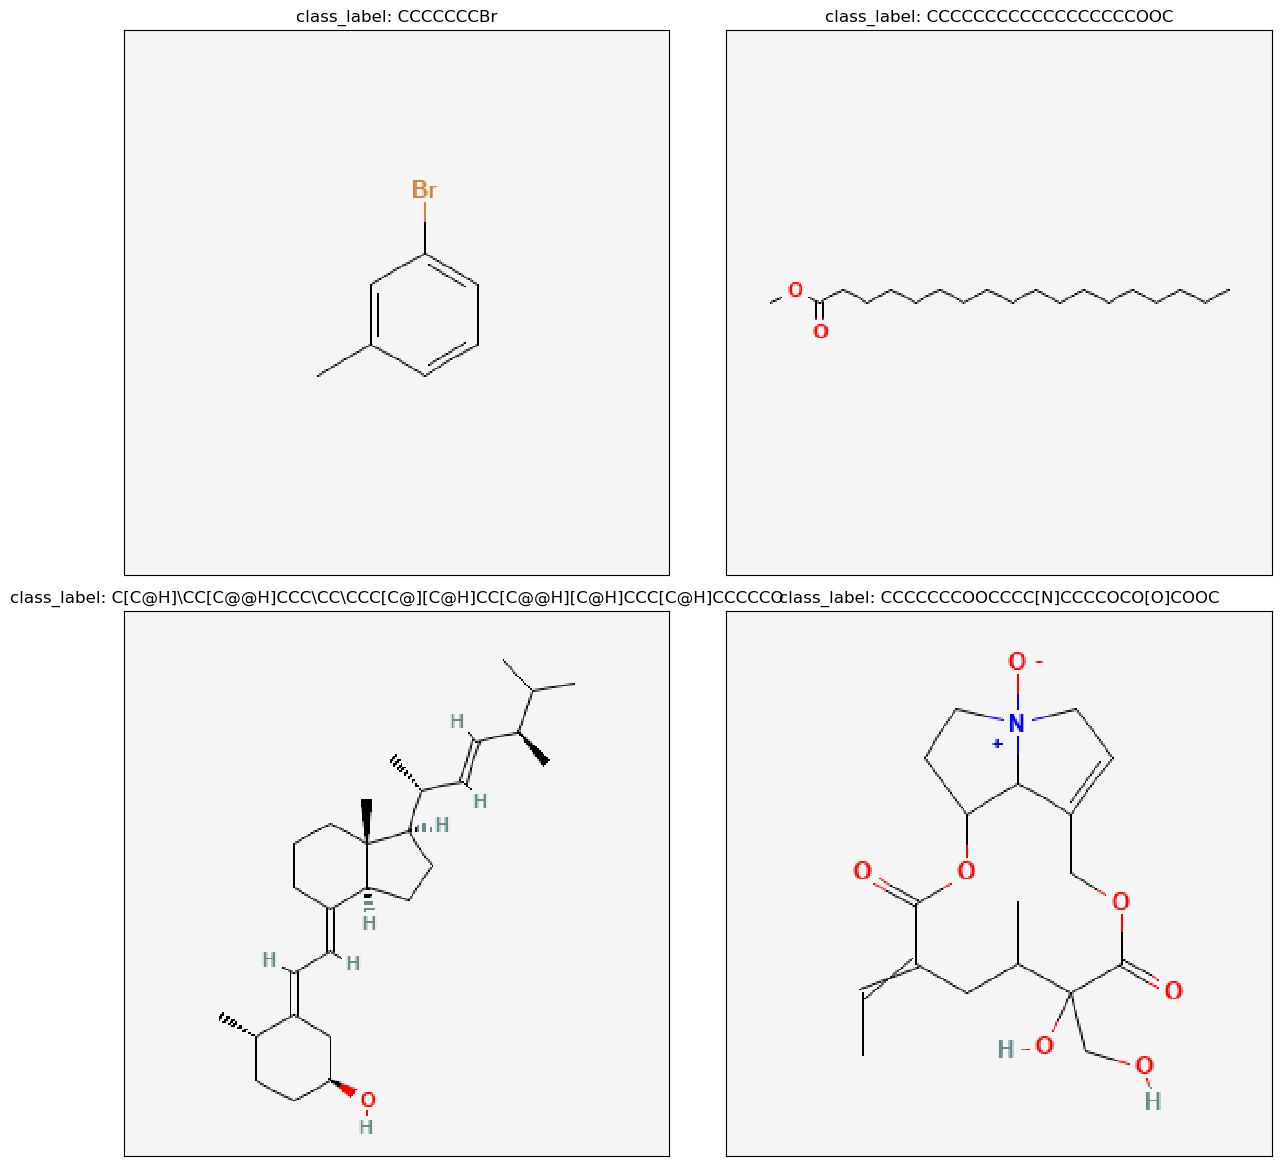

In [362]:
x,y = next(practiceDataGen)
print (x.shape)
#output: (8, 224, 224, 3)
#print (y)
#output: [0 1 1 4 3 1 4 2]

fig = plt.figure(1,figsize=(12,12))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.tight_layout()
  x[i] = x[i][:,:,::-1]
  plt.imshow(x[i], interpolation='none')
  plt.title("class_label: {}".format(testingASCIItoSMILES(y[i])))
  plt.xticks([])
  plt.yticks([])

## Part 4: The CNN part?
Idk as of now (4/4/25) if this is the part for making the layers for the CNN.   
To make the layers, I'm following a video to get my general bearings: <a href="https://www.youtube.com/watch?v=fTw3K8D5xDs">How to Design a Convolutional Neural Network</a>   
The images are 300 x 300 pixels. 

In [333]:
#making the actual data generators
trainGen = generator(sampleTrain)
testGen = generator(sampleTest)

This is what this website had, gonna follow the general layout and modify the parameters as needed: <a href="https://www.mathworks.com/help/deeplearning/ug/train-a-convolutional-neural-network-for-regression.html"> Train a Convolutional Neural Network for Regression</a>


In [366]:
#now the layers
#I'm gonna make the CNN first
cnnModel = keras.models.Sequential()
cnnModel.add(layers.InputLayer(input_shape=(300, 300, 3)))
cnnModel.add(layers.Conv2D(8, (3, 3), padding="valid", activation="relu"))
cnnModel.add(layers.BatchNormalization())
cnnModel.add(layers.AvgPool2D(pool_size=(2, 2), strides=2))
cnnModel.add(layers.Conv2D(16, (3, 3), padding="valid", activation="relu"))
cnnModel.add(layers.BatchNormalization())
cnnModel.add(layers.AvgPool2D(pool_size=(2, 2), strides=2))
cnnModel.add(layers.Conv2D(32, (3, 3), padding="valid", activation="relu"))
cnnModel.add(layers.BatchNormalization())
cnnModel.add(layers.Conv2D(32, (3, 3), padding="valid", activation="relu"))
cnnModel.add(layers.BatchNormalization())
#cnnModel.add(layers.Flatten())
cnnModel.add(layers.GlobalAveragePooling2D())
cnnModel.add(layers.Dense(250, activation="relu"))

cnnModel.summary()


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 298, 298, 8)       224       
                                                                 
 batch_normalization_32 (Bat  (None, 298, 298, 8)      32        
 chNormalization)                                                
                                                                 
 average_pooling2d_16 (Avera  (None, 149, 149, 8)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_33 (Conv2D)          (None, 147, 147, 16)      1168      
                                                                 
 batch_normalization_33 (Bat  (None, 147, 147, 16)     64        
 chNormalization)                                                
                                                     

In [367]:
#now the RNN
rnnModel = keras.models.Sequential()
rnnModel.add(layers.InputLayer(input_shape=(250,)))
rnnModel.add(layers.Reshape((250, 1)))
rnnModel.add(layers.Masking(mask_value=0)) #we gotta add this bc we don't want to confuse the padding with the data, so al 0's are just the pad
rnnModel.add(layers.LSTM(128, return_sequences=True))
rnnModel.add(layers.TimeDistributed(layers.Dense(95, activation="softmax"))) #93 bc thats how many ascii codes i'm expecting
#going from ascii space (32) to ascii ~ (126), but also have to include padding which is 0
#careful with this part, I modified the labels so they are -31
#so ascii range went 32 - 126 to 1 - 95
# 0 is pad, so range is 0 - 95

rnnModel.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_13 (Reshape)        (None, 250, 1)            0         
                                                                 
 masking_5 (Masking)         (None, 250, 1)            0         
                                                                 
 lstm_12 (LSTM)              (None, 250, 128)          66560     
                                                                 
 time_distributed_5 (TimeDis  (None, 250, 95)          12255     
 tributed)                                                       
                                                                 
Total params: 78,815
Trainable params: 78,815
Non-trainable params: 0
_________________________________________________________________


In [368]:
#now combine the models
model = keras.models.Sequential()
model.add(cnnModel)
model.add(rnnModel)

In [369]:
from tensorflow.keras.metrics import MeanSquaredError, CategoricalAccuracy
# the shape is (32, 300, 300, 3) (taken from above)
model.build(input_shape=(32, 300, 300, 3))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', CategoricalAccuracy()])
model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_32 (Sequential)  (None, 250)               23882     
                                                                 
 sequential_33 (Sequential)  (None, 250, 95)           78815     
                                                                 
Total params: 102,697
Trainable params: 102,521
Non-trainable params: 176
_________________________________________________________________


In [370]:
#numbTrainSample = 
#def nextTrainBatch:
from tensorflow.keras.callbacks import EarlyStopping #chatGPT recommends bc I got terrible loss and accuracy
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


model.fit(
        trainGen,
        steps_per_epoch= 32, #batch size
        epochs=20,
        validation_data=testGen,
        validation_steps= 32, #batch size
        callbacks= [early_stopping]) 

Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node 'Equal_1' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Applications/anaconda/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/Applications/anaconda/anaconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/Applications/anaconda/anaconda3/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/vq/0vtj01pd5yd4wh8k78wcwqn9fw3g_4/T/ipykernel_1082/2824182076.py", line 7, in <module>
      model.fit(
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/keras/engine/training.py", line 1055, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/keras/engine/training.py", line 1149, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/keras/engine/compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/keras/utils/metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/keras/metrics/base_metric.py", line 691, in update_state
      matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/keras/metrics/accuracy_metrics.py", line 169, in <lambda>
      lambda y_true, y_pred: metrics_utils.sparse_categorical_matches(
    File "/Applications/anaconda/anaconda3/lib/python3.11/site-packages/keras/utils/metrics_utils.py", line 971, in sparse_categorical_matches
      matches = tf.cast(tf.equal(y_true, y_pred), backend.floatx())
Node: 'Equal_1'
Incompatible shapes: [32] vs. [32,250]
	 [[{{node Equal_1}}]] [Op:__inference_train_function_6419614]